<a href="https://colab.research.google.com/github/alexdel1/graph_csv_to_svg/blob/main/csv_to_svg_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Parse the CSV data
csv_data = r"""source,target,label,style
éq. déc.,déc.,3.1.23
éq. irr.,irr.,3.1.24
éq. comp. réd.,comp. réd.,3.1.25
unit.,irr.,3.2.3,dashed
éq. unit.,éq. irr.,éq. 3.2.3,dashed
unit.,déc.,3.2.3,dashed
éq. unit.,éq. déc.,éq. 3.2.3,dashed
fini,éq. unit.,3.2.4
fini,irr.,3.2.5,dashed
fini,déc.,3.2.5,dashed
irr.,indéc.,3.2.7 pas la réciproque
fini,comp. réd.,3.2.8 Maschke
$\phi \nsim \rho$,$\frac{\gamma}{x^2}$,test
"""

In [ ]:
csv_node=r"""name,texlbl
fini,$\mathrm{card}(G)<\infty$
"""

!sudo apt update
!sudo apt install graphviz libgraphviz-dev
#ne pas oublier la version dev de graphviz

!pip install pygraphviz

In [ ]:
import pandas as pd
import io
import unicodedata
import re
import networkx as nx
import pygraphviz # Import the Graph class
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import SVG
import subprocess

In [ ]:

# Function to convert text to a valid Python variable name
def to_variable_name(text):
    # Normalize the text to decompose accented characters
    text = unicodedata.normalize('NFKD', str(text))

    # Remove non-ASCII characters and replace with their base letters
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove remaining special characters and replace spaces with underscores
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace(' ', '_')

    return text

def csv_to_pd(csv_data,csv_node=""):
    # Create DataFrame A
    A = pd.read_csv(io.StringIO(csv_data))
    D = ""
       # Create DataFrame B with distinct elements from first two columns
    B_data = pd.concat([A['source'], A['target']]).drop_duplicates()
    B = pd.DataFrame({
        'texlbl': B_data,
        'name': B_data.apply(to_variable_name)
    })

    #If a node CSV is provided, update texlbl in B with node labels
    if csv_node:
        D = pd.read_csv(io.StringIO(csv_node))
        #print(D)
        #print(B)
        # Merge B with D to update texlbl
        B = B.merge(D[['name', 'texlbl']], on='name', how='left')
        #print(B)
        # Update texlbl column, keeping original if no match in D
        B['texlbl'] = B['texlbl_y'].fillna(B['texlbl_x'])

        # Drop the temporary merge columns
        B = B.drop(columns=['texlbl_x', 'texlbl_y'])
        #print(B)

    # Create DataFrame C

    # Create DataFrame C
    C = pd.DataFrame({
        'source_name': A['source'].apply(to_variable_name),
        'target_name': A['target'].apply(to_variable_name),
        'label': A['label'],
        'style': A.iloc[:, 3]
    })

    C.fillna("solid", inplace=True)
    return (B,C)
(B,C)=csv_to_pd(csv_data,csv_node)

print("\nDataFrame B:")
print(B)
print("\nDataFrame C:")
print(C)


DataFrame B:
            name                     texlbl
0         eq_dec                   éq. déc.
1         eq_irr                   éq. irr.
2    eq_comp_red             éq. comp. réd.
3           unit                      unit.
4        eq_unit                  éq. unit.
5           fini  $\mathrm{card}(G)<\infty$
6            irr                       irr.
7   phi_nsim_rho          $\phi \nsim \rho$
8            dec                       déc.
9       comp_red                 comp. réd.
10         indec                     indéc.
11   fracgammax2       $\frac{\gamma}{x^2}$

DataFrame C:
     source_name  target_name                    label   style
0         eq_dec          dec                   3.1.23   solid
1         eq_irr          irr                   3.1.24   solid
2    eq_comp_red     comp_red                   3.1.25   solid
3           unit          irr                    3.2.3  dashed
4        eq_unit       eq_irr                éq. 3.2.3  dashed
5           unit      

In [ ]:

def pd_to_nx(B,C):
    # Assuming B and C DataFrames are already created from the previous code

    # Create an empty graph
    G = nx.DiGraph()  # Using DiGraph for a directed graph

    # Add nodes from table B
    # Use the 'name' column as node identifier and 'texlbl' as a node attribute
    for _, row in B.iterrows():
        G.add_node(
            row['name'],  # Use the converted variable name as node identifier
            texlbl=row['texlbl']  # Original label as a node attribute
        )

    # Add edges from table C
    for _, row in C.iterrows():
        # Add an edge using the converted source and target names
        G.add_edge(
            row['source_name'],  # Source node
            row['target_name'],  # Target node
            style=row.get('style', ''),  # Style attribute
            texlbl=row.get('label', '')  # Label attribute
        )
    return G
G = pd_to_nx(B,C)
# Optional: Verify the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Optional: Print node and edge details
print("\nNodes:")
for node in G.nodes(data=True):
    print(node)

print("\nEdges:")
for edge in G.edges(data=True):
    print(edge)

Number of nodes: 12
Number of edges: 13

Nodes:
('eq_dec', {'texlbl': 'éq. déc.'})
('eq_irr', {'texlbl': 'éq. irr.'})
('eq_comp_red', {'texlbl': 'éq. comp. réd.'})
('unit', {'texlbl': 'unit.'})
('eq_unit', {'texlbl': 'éq. unit.'})
('fini', {'texlbl': '$\\mathrm{card}(G)<\\infty$'})
('irr', {'texlbl': 'irr.'})
('phi_nsim_rho', {'texlbl': '$\\phi \\nsim \\rho$'})
('dec', {'texlbl': 'déc.'})
('comp_red', {'texlbl': 'comp. réd.'})
('indec', {'texlbl': 'indéc.'})
('fracgammax2', {'texlbl': '$\\frac{\\gamma}{x^2}$'})

Edges:
('eq_dec', 'dec', {'style': 'solid', 'texlbl': '3.1.23'})
('eq_irr', 'irr', {'style': 'solid', 'texlbl': '3.1.24'})
('eq_comp_red', 'comp_red', {'style': 'solid', 'texlbl': '3.1.25'})
('unit', 'irr', {'style': 'dashed', 'texlbl': '3.2.3'})
('unit', 'dec', {'style': 'dashed', 'texlbl': '3.2.3'})
('eq_unit', 'eq_irr', {'style': 'dashed', 'texlbl': 'éq. 3.2.3'})
('eq_unit', 'eq_dec', {'style': 'dashed', 'texlbl': 'éq. 3.2.3'})
('fini', 'eq_unit', {'style': 'solid', 'texlbl'

In [ ]:
# Convertir le graphe en pygraphviz AGraph
#A = to_agraph(G)

# Personnaliser le style
#A.graph_attr.update(rankdir="LR")  # Orientation de gauche à droite
#A.node_attr.update(fontsize="10", style="filled")
#A.edge_attr.update(color="black", arrowsize="0.5")
#A.graph_attr.update(encoding="utf-8")

# Écrire directement dans un fichier DOT
#A.write("graph.dot")

def nx_to_dot(G,tex_file_path="graph"):
    dot_graph = to_pydot(G)

    # Save the DOT file
    with open(tex_file_path+".dot", "w", encoding="utf-8") as f:
        f.write(dot_graph.to_string())
    return(dot_graph)
dot_graph=nx_to_dot(G)
print(dot_graph.to_string())



# Écrire directement dans un fichier DOT
#A.write("graph.dot")



# Method 3: Using read().splitlines()
with open('graph.dot', 'r') as file:
    lines = file.read().splitlines()
    for line in lines:
        print(line)
# Method 3: Using read().splitlines()
with open('graph.dot', 'r') as file:
    lines = file.read().splitlines()
    for line in lines:
        print(line)

strict digraph {
eq_dec [texlbl="éq. déc."];
eq_irr [texlbl="éq. irr."];
eq_comp_red [texlbl="éq. comp. réd."];
unit [texlbl="unit."];
eq_unit [texlbl="éq. unit."];
fini [texlbl="$\mathrm{card}(G)<\infty$"];
irr [texlbl="irr."];
phi_nsim_rho [texlbl="$\phi \nsim \rho$"];
dec [texlbl="déc."];
comp_red [texlbl="comp. réd."];
indec [texlbl="indéc."];
fracgammax2 [texlbl="$\frac{\gamma}{x^2}$"];
eq_dec -> dec [style=solid, texlbl=3.1.23];
eq_irr -> irr [style=solid, texlbl=3.1.24];
eq_comp_red -> comp_red [style=solid, texlbl=3.1.25];
unit -> irr [style=dashed, texlbl=3.2.3];
unit -> dec [style=dashed, texlbl=3.2.3];
eq_unit -> eq_irr [style=dashed, texlbl="éq. 3.2.3"];
eq_unit -> eq_dec [style=dashed, texlbl="éq. 3.2.3"];
fini -> eq_unit [style=solid, texlbl=3.2.4];
fini -> irr [style=dashed, texlbl=3.2.5];
fini -> dec [style=dashed, texlbl=3.2.5];
fini -> comp_red [style=solid, texlbl="3.2.8 Maschke"];
irr -> indec [style=solid, texlbl="3.2.7 pas la réciproque"];
phi_nsim_rho -> fracgamm

!pip install dot2tex

!sudo apt install pdf2svg

!sudo apt update
!sudo apt install texlive-xetex


!dot2tex  --docpreamble "\usepackage[utf8]{inputenc} \usepackage[T1]{fontenc} \usepackage{amssymb}" -tmath --autosize graph.dot > graph.tex
#!latex

In [ ]:
def insert_resizebox(tex_file_path):
    """Inserts \resizebox{\linewidth}{!}{ and } into a LaTeX file.

    Args:
        tex_file_path: Path to the LaTeX file.

    Returns:
        None
    """

    with open(tex_file_path, 'r') as f:
        lines = f.readlines()

    # Find the line containing \pagestyle{empty}
    for i, line in enumerate(lines):
        if r"\pagestyle{empty}" in line:
            lines.insert(i + 1, r"\resizebox{\linewidth}{!}{")
            break

    # Find the line containing \end{document}
    for i,line in enumerate(lines):
        if r"\end{document}" in line:
            lines.insert(i-1, r"}")
            break

    with open(tex_file_path, 'w') as f:
        f.writelines(lines)

# Example usage:
tex_file_path = "graph.tex"
insert_resizebox(tex_file_path)

# Parse the CSV data
csv_data = r"""source,target,label,style
twts,$t^2$,$w_4$
éq. déc.,déc.,3.1.23
éq. irr.,irr.,3.1.24
éq. comp. réd.,comp. réd.,3.1.25
unit.,irr.,3.2.3,dashed
éq. unit.,éq. irr.,éq. 3.2.3,dashed
unit.,déc.,3.2.3,dashed
éq. unit.,éq. déc.,éq. 3.2.3,dashed
fini,éq. unit.,3.2.4
fini,irr.,3.2.5,dashed
fini,déc.,3.2.5,dashed
irr.,indéc.,3.2.7 pas la réciproque
fini,comp. réd.,3.2.8 Maschke
$\phi \nsim \rho$,$\frac{\gamma}{x^2}$,test
"""

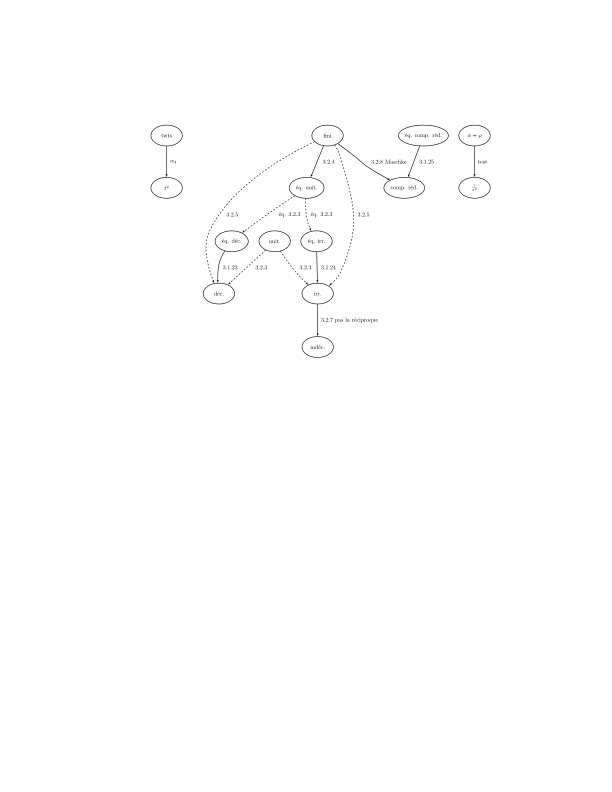

In [ ]:
tex_file_path = "graph2"
(B,C)=csv_to_pd(csv_data)
G = pd_to_nx(B,C)
nx_to_dot(G,tex_file_path)


# Using subprocess for shell commands
subprocess.run(f'dot2tex --docpreamble "\\usepackage[utf8]{{inputenc}} \\usepackage[T1]{{fontenc}} \\usepackage{{amssymb}}" -tmath --autosize "{tex_file_path}.dot" > "{tex_file_path}.tex"', shell=True)
insert_resizebox(f"{tex_file_path}.tex")
subprocess.run(f'xelatex "{tex_file_path}.tex"', shell=True)

subprocess.run(f'pdf2svg "{tex_file_path}.pdf" "{tex_file_path}.svg"', shell=True)

SVG(f"{tex_file_path}.svg")

In [ ]:
#
#!dot2tex  --docpreamble "\usepackage[utf8]{inputenc} \usepackage[T1]{fontenc} \usepackage{amssymb}" -tmath --autosize testnode.dot > testnode.tex
#!latex

In [ ]:
#!xelatex testnode.tex
#!pdf2svg testnode.pdf testnode.svg

#SVG("testnode.svg")

csv_node=r"""name,texlbl
fini,$\text{card}(G)<\infty$
"""

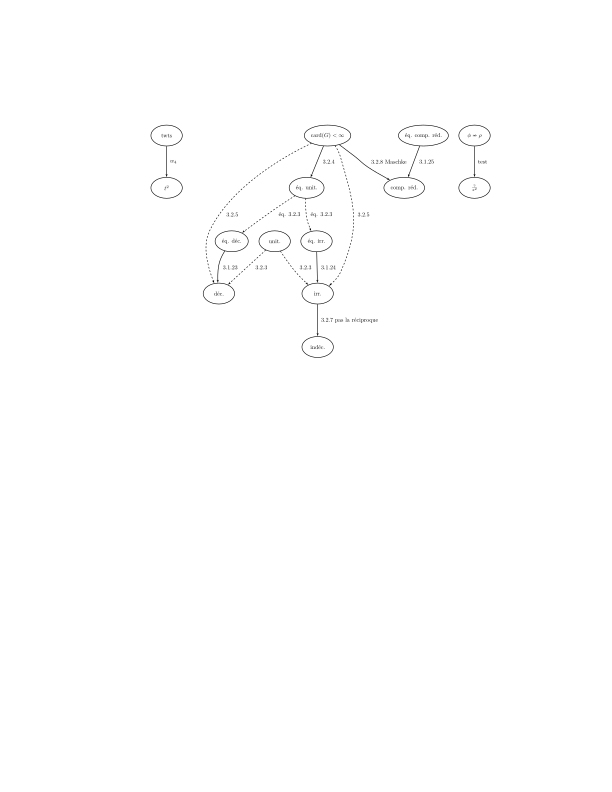

In [ ]:


def csv_to_svg(csv_data,csv_node="",tex_file_path = "graph"):
    (B,C)=csv_to_pd(csv_data,csv_node)
    G = pd_to_nx(B,C)
    nx_to_dot(G,tex_file_path)


    # Using subprocess for shell commands
    subprocess.run(f'dot2tex --docpreamble "\\usepackage[utf8]{{inputenc}} \\usepackage[T1]{{fontenc}} \\usepackage{{amssymb}}" -tmath --autosize "{tex_file_path}.dot" > "{tex_file_path}.tex"', shell=True)
    insert_resizebox(f"{tex_file_path}.tex")
    subprocess.run(f'xelatex "{tex_file_path}.tex"', shell=True)

    subprocess.run(f'pdf2svg "{tex_file_path}.pdf" "{tex_file_path}.svg"', shell=True)

    display(SVG(f"{tex_file_path}.svg"))

#csv_to_svg(csv_data)
csv_to_svg(csv_data,csv_node,"testnode")